In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

In [2]:
# Load the datasets
Train = pd.read_csv('Train-1542865627584.csv')
Beneficiary = pd.read_csv('Train_Beneficiarydata-1542865627584.csv')
Inpatient = pd.read_csv('Train_Inpatientdata-1542865627584.csv')
Outpatient = pd.read_csv('Train_Outpatientdata-1542865627584.csv')

In [3]:
#Inpatient dataset
#Convert columns to datetime from Inpatient dataset
Inpatient['ClaimStartDt'] = pd.to_datetime(Inpatient['ClaimStartDt'])
Inpatient['ClaimEndDt'] = pd.to_datetime(Inpatient['ClaimEndDt'])

In [4]:
# Create Claim-duration column from Inpatient dataset
Inpatient['Claim_duration']=(Inpatient['ClaimEndDt']-Inpatient['ClaimStartDt']).dt.days

In [5]:
# Get provider-level Claim_duration from Inpatient
Inpatient_provider_average_claim_duration = (
    Inpatient.groupby('Provider', as_index=False)['Claim_duration']
    .mean()
    .round()
)

Inpatient_provider_average_claim_duration = Inpatient_provider_average_claim_duration.rename(
    columns={'Claim_duration': 'IP_average_claim_duration'}
)

In [6]:
Inpatient_provider_average_claim_duration

,Provider,IP_average_claim_duration
0,PRV51001,5.0
1,PRV51003,5.0
2,PRV51007,5.0
3,PRV51008,4.0
4,PRV51011,5.0
...,...,...
2087,PRV57719,14.0
2088,PRV57728,4.0
2089,PRV57729,6.0
2090,PRV57732,5.0


In [7]:
# Outpatient dataset
#Convert columns to datetime from Outpatient dataset
Outpatient['ClaimStartDt'] = pd.to_datetime(Outpatient['ClaimStartDt'])
Outpatient['ClaimEndDt'] = pd.to_datetime(Outpatient['ClaimEndDt'])

In [8]:
# Create Claim-duration column from Outpatient dataset
Outpatient['Claim_duration']=(Outpatient['ClaimEndDt']-Outpatient['ClaimStartDt']).dt.days

In [9]:
# Get provider-level Claim_duration from Outpatient
Outpatient_provider_average_claim_duration = (
    Outpatient.groupby('Provider', as_index=False)['Claim_duration']
    .mean()
    .round()
)

Outpatient_provider_average_claim_duration = Outpatient_provider_average_claim_duration.rename(
    columns={'Claim_duration': 'OP_average_claim_duration'}
)

In [10]:
Outpatient_provider_average_claim_duration

,Provider,OP_average_claim_duration
0,PRV51001,1.0
1,PRV51003,2.0
2,PRV51004,1.0
3,PRV51005,1.0
4,PRV51007,1.0
...,...,...
5007,PRV57759,2.0
5008,PRV57760,0.0
5009,PRV57761,1.0
5010,PRV57762,0.0


In [11]:
# Outer Merge on Provider
provider_claim_duration= pd.merge(
    Inpatient_provider_average_claim_duration,
    Outpatient_provider_average_claim_duration,
    on='Provider',
    how='outer'    
).fillna(0)

In [12]:
provider_claim_duration

,Provider,IP_average_claim_duration,OP_average_claim_duration
0,PRV51001,5.0,1.0
1,PRV51003,5.0,2.0
2,PRV51004,0.0,1.0
3,PRV51005,0.0,1.0
4,PRV51007,5.0,1.0
...,...,...,...
5405,PRV57759,0.0,2.0
5406,PRV57760,0.0,0.0
5407,PRV57761,0.0,1.0
5408,PRV57762,0.0,0.0


In [13]:
# Merge with Fraud Label
df_final= pd.merge(
    provider_claim_duration,
    Train,
    on='Provider',
    how='outer'   
)

In [14]:
df_final

,Provider,IP_average_claim_duration,OP_average_claim_duration,PotentialFraud
0,PRV51001,5.0,1.0,No
1,PRV51003,5.0,2.0,Yes
2,PRV51004,0.0,1.0,No
3,PRV51005,0.0,1.0,Yes
4,PRV51007,5.0,1.0,No
...,...,...,...,...
5405,PRV57759,0.0,2.0,No
5406,PRV57760,0.0,0.0,No
5407,PRV57761,0.0,1.0,No
5408,PRV57762,0.0,0.0,No


In [15]:
# Save final_df as a CSV file
df_final.to_csv("Merge_providerlevel_claim_duration.csv", index=False)

<Figure size 1000x500 with 0 Axes>

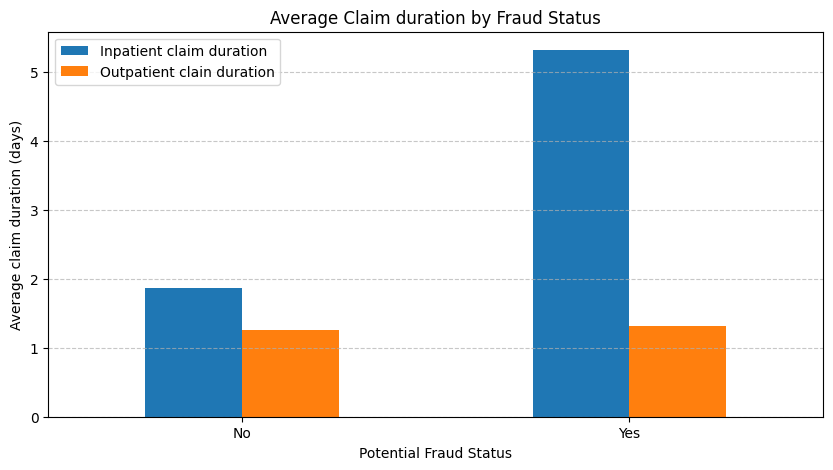

In [16]:
# visualization
import matplotlib.pyplot as plt

# Grouping by PotentialFraud and calculating mean claim duration
fraud_summary = df_final.groupby("PotentialFraud")[
    ["IP_average_claim_duration", "OP_average_claim_duration"]
].mean()

# Plotting Inpatient and Outpatient claim duration comparison
plt.figure(figsize=(10, 5))
fraud_summary.plot(kind="bar", figsize=(10, 5), rot=0)
plt.title("Average Claim duration by Fraud Status")
plt.ylabel("Average claim duration (days)")
plt.xlabel("Potential Fraud Status")
plt.xticks(rotation=0)
plt.legend(["Inpatient claim duration", "Outpatient clain duration"])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


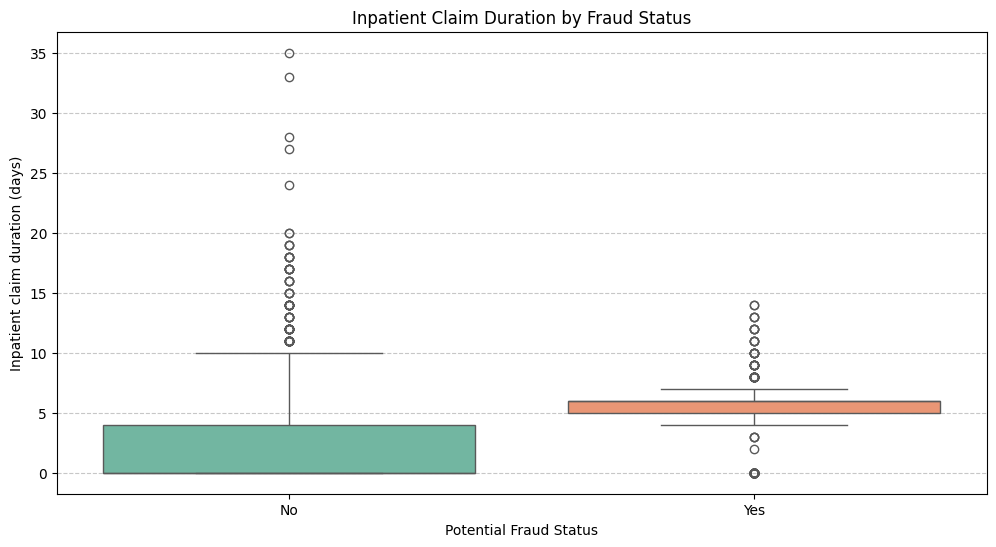

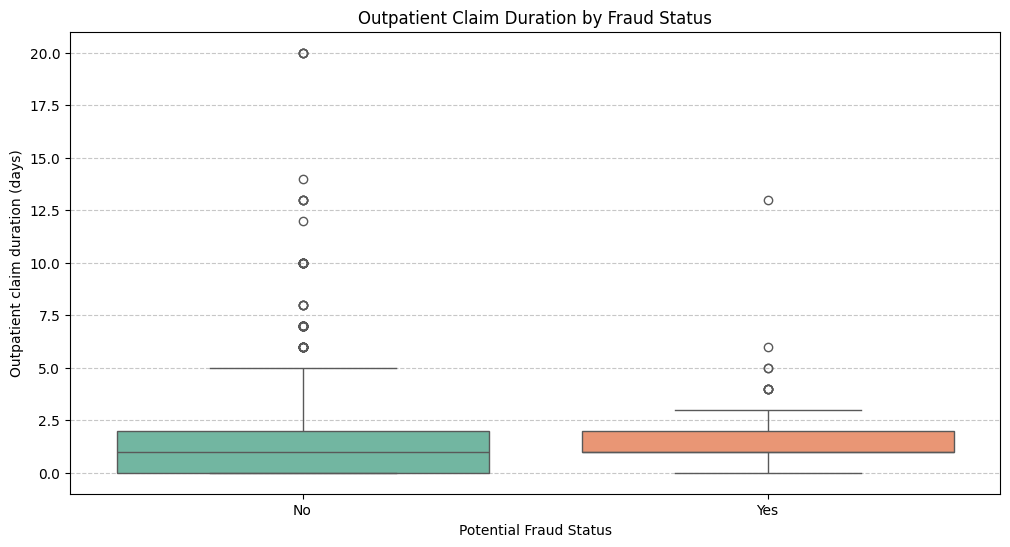

In [19]:
# Boxplot comparison of Inpatient and Outpatient claim duration by PotentialFraud status
import matplotlib.pyplot as plt
import seaborn as sns 

plt.figure(figsize=(12, 6))

# Plotting Inpatient claim duration by PotentialFraud status
sns.boxplot(data=df_final, x='PotentialFraud', y='IP_average_claim_duration', hue='PotentialFraud', palette='Set2')
plt.title("Inpatient Claim Duration by Fraud Status")
plt.ylabel("Inpatient claim duration (days)")
plt.xlabel("Potential Fraud Status")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Plotting Outpatient claim duration by PotentialFraud status
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_final, x='PotentialFraud', y='OP_average_claim_duration', hue='PotentialFraud', palette='Set2')
plt.title("Outpatient Claim Duration by Fraud Status")
plt.ylabel("Outpatient claim duration (days)")
plt.xlabel("Potential Fraud Status")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()